# Intro to Food Vision Mobile 🍔 👀📱

(This project was inspired by [@mrdbourke's](https://github.com/mrdbourke) excellent TF course, check it out: [Tensorflow Deep Learning](https://github.com/mrdbourke/tensorflow-deep-learning) )

## See the live app [here](https://tomwalczak.github.io/food-vision-mobile-tensorflowjs/)

I was curious about how two well-known models, ResNet50 and ImageNet (trained on Food101 dataset), would perform runnining on a smartphone, in a browser using TensorFlow JS.

Using TFJS makes it very easy to test these models in the wild - would they perform OK?

My approach was to extract image features from ResNet50V2, ImageNetV2, fit them to Food101 dataset (10% and 100%) and finally convert them to Tensorflow JS.

#Load helper functions

In [18]:
import tensorflow as tf

In [4]:
# Get helper functions file (credit: @mrdbourke)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-01 19:55:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-01 19:55:59 (95.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# View random images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images(target_dir, target_class, how_many=9):
  # Set up target folder
  target_folder = target_dir + target_class

  how_many = 16 if (how_many > 16 or how_many < 1) else how_many
  
  # Get a random image path
  random_images = random.sample(os.listdir(target_folder), how_many)

  # Read in the image and plot it using matplotlib
  
  plt.figure(figsize=(12,16))
  for idx, random_image in enumerate(random_images):
    img = mpimg.imread(target_folder + "/" + random_image)
    plt.subplot(4, 4, idx + 1)
    plt.imshow(img)
    plt.title(f"{target_class} \n {random_image} \n {img.shape}")
    plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image





In [6]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-8d5c1675-6547-12fe-b097-bfe22865c762)


In [7]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import walk_through_dir, create_tensorboard_callback, plot_loss_curves, calculate_results, unzip_data

# Download data - 10% of Food101

In [4]:
# Download data
!wget https://mldatatwk.s3.us-east-2.amazonaws.com/101_food_classes_10_percent.zip

--2021-06-01 08:07:16--  https://mldatatwk.s3.us-east-2.amazonaws.com/101_food_classes_10_percent.zip
Resolving mldatatwk.s3.us-east-2.amazonaws.com (mldatatwk.s3.us-east-2.amazonaws.com)... 52.219.106.250
Connecting to mldatatwk.s3.us-east-2.amazonaws.com (mldatatwk.s3.us-east-2.amazonaws.com)|52.219.106.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  16.3MB/s    in 98s     

2021-06-01 08:08:54 (15.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Unzip the downloaded file

unzip_data("101_food_classes_10_percent.zip")

In [6]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")


## Creating data loaders

In [7]:
# Setup data inputs

from keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)

# Gotcha - Keras' rescaling layers are to compatible with TF JS, this is an alternative
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

print("Training images: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=IMAGE_SHAPE, # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

print("Testing images:") 
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=IMAGE_SHAPE,
                                               class_mode="categorical",
                                               seed=42)



Training images: 
Found 7575 images belonging to 101 classes.
Testing images:
Found 25250 images belonging to 101 classes.


In [ ]:
# Double-check we have correct food classes
len(train_data.classes)
food_classes = [food_class for food_class in train_data.class_indices]
food_classes

## Explore data

Image shape: (512, 512, 3)


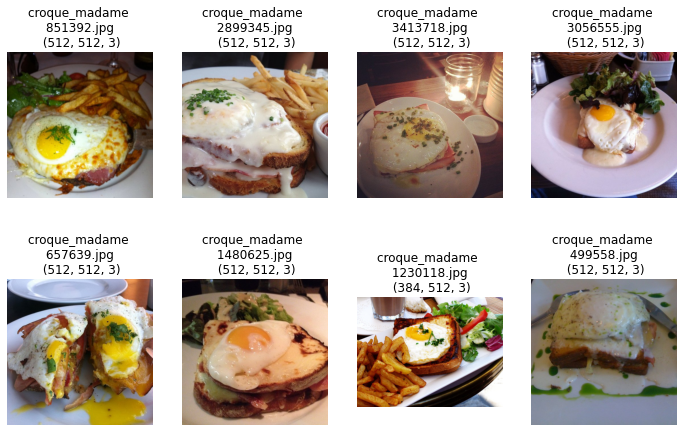

In [28]:
view_random_images('101_food_classes_10_percent/test/', random.choice(food_classes), how_many=8)

In [ ]:
## Double-check if pixel values are being rescaled
for elem in train_data:
  print(elem[0][0])
  break

# Build and train a ResNet50V2 feature extract model on 10% Food101 data (baseline)

In [12]:
js_model_path = "resnet_js_model"
saved_model_path = "resnet_model"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

resnet_feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         name="feature_extraction_layer")


x = resnet_feature_extractor_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)


outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [13]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               206949    
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/simple_feature_extract_resnet50V2_dropout_03_resnet_5/20210527-152813
Epoch 1/5
237/237 [==============================] - 64s 195ms/step - loss: 3.5910 - accuracy: 0.2088 - val_loss: 2.3357 - val_accuracy: 0.4213
Epoch 2/5
237/237 [==============================] - 54s 228ms/step - loss: 2.0822 - accuracy: 0.4681 - val_loss: 2.1828 - val_accuracy: 0.4438
Epoch 3/5
237/237 [==============================] - 44s 185ms/step - loss: 1.6262 - accuracy: 0.5714 - val_loss: 2.0872 - val_accuracy: 0.4624
Epoch 4/5
237/237 [==============================] - 54s 226ms/step - loss: 1.3079 - accuracy: 0.6475 - val_loss: 2.0844 - val_accuracy: 0.4771
Epoch 5/5
237/237 [==============================] - 53s 226ms/step - loss: 1.0857 - accuracy: 0.7086 - val_loss: 2.1332 - val_accuracy: 0.4620


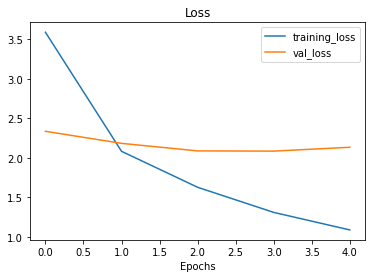

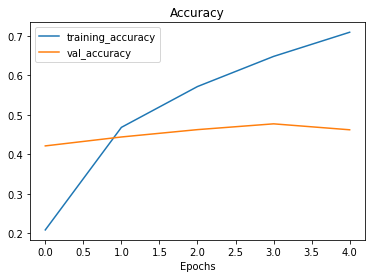

In [14]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "simple_feature_extract_resnet50V2_dropout_03")]
                                 )
plot_loss_curves(resnet_history)

In [18]:
resnet_model.evaluate(test_data)

790/790 [==============================] - 112s 142ms/step - loss: 2.0871 - accuracy: 0.4780


[2.0870752334594727, 0.47798019647598267]

In [20]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
resnet_model.save(saved_model_path)

# Save model backup to Google Drive 
resnet_model.save(save_dir+saved_model_path)


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: resnet_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/simple_feature_extract_resnet50V2_successful_js/resnet_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/simple_feature_extract_resnet50V2_successful_js/resnet_model/assets


## Convert ResNet model to TFJS

In [ ]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

# Build and train a MobileNet V2 feature extraction model on 10% Food101 data

In [35]:
js_model_path = "mobilenet_v2_js_model"
saved_model_path = "mobilenet_v2_model"

mobile_net_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

feature_extract_layer = hub.KerasLayer(mobile_net_v2_url,
                                         trainable=False,
                                         name="feature_extract_layer")

x = feature_extract_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Saving TensorBoard log files to: tensorflow_hub/feature_extract_mobile_net_v2/20210601-091009
Epoch 1/5
237/237 [==============================] - 69s 215ms/step - loss: 3.4461 - accuracy: 0.2226 - val_loss: 2.3014 - val_accuracy: 0.4233
Epoch 2/5
237/237 [==============================] - 50s 209ms/step - loss: 2.0749 - accuracy: 0.4752 - val_loss: 1.9872 - val_accuracy: 0.4901
Epoch 3/5
237/237 [==============================] - 58s 244ms/step - loss: 1.6696 - accuracy: 0.5645 - val_loss: 1.9534 - val_accuracy: 0.4956
Epoch 4/5
237/237 [==============================] - 58s 244ms/step - loss: 1.4094 - accuracy: 0.6306 - val_loss: 1.8289 - val_accuracy: 0.5289
Epoch 5/5
237/237 [==============================] - 58s 243ms/step - loss: 1.2158 - accuracy: 0.6779 - val_loss: 1.8507 - val_accuracy: 0.5249


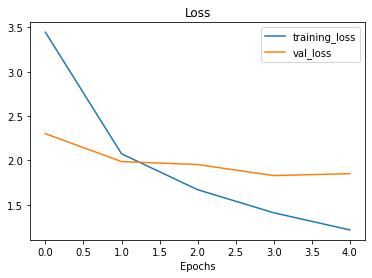

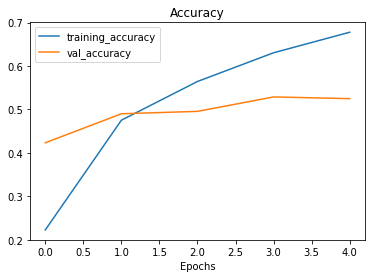

In [38]:
model_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "feature_extract_mobile_net_v2")]
                                 )
plot_loss_curves(model_history)

### MobileNetV2 on the same data performs better than ResNet50


In [39]:
# 52% vs 46% on ResNet, despite on 2.4M params (ResNet is 23.7M)
model.evaluate(test_data)

790/790 [==============================] - 123s 156ms/step - loss: 1.8354 - accuracy: 0.5244


[1.8354127407073975, 0.5243960618972778]

In [41]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
model.save(saved_model_path)

# Save model backup to Google Drive 
model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_js_model/mobilenet_v2_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_js_model/mobilenet_v2_model/assets


In [ ]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

# Download 100% of Food101

In [8]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [9]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [64]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [65]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [66]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [67]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [68]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [69]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 24
  Class name (str form): clam_chowder
        


In [70]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[41, 32, 27],
        [43, 34, 29],
        [43, 34, 29],
        ...,
        [53, 50, 41],
        [48, 48, 38],
        [45, 45, 35]],

       [[40, 31, 26],
        [43, 34, 29],
        [45, 36, 31],
        ...,
        [46, 43, 34],
        [46, 46, 36],
        [49, 49, 39]],

       [[40, 31, 26],
        [44, 35, 30],
        [46, 37, 32],
        ...,
        [48, 45, 36],
        [48, 48, 40],
        [52, 52, 44]],

       ...,

       [[90, 78, 66],
        [93, 81, 69],
        [95, 83, 71],
        ...,
        [20,  8,  8],
        [20,  8,  8],
        [21,  9,  9]],

       [[93, 81, 69],
        [95, 83, 71],
        [96, 84, 72],
        ...,
        [21,  9,  9],
        [22, 10, 10],
        [23, 11, 11]],

       [[98, 86, 74],
        [99, 87, 75],
        [97, 85, 73],
        ...,
        [24, 12, 12],
        [26, 14, 14],
        [27, 15, 15]]], dtype=uint8)>

In [71]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=1>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

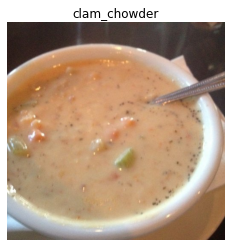

In [72]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [73]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape

  return tf.cast(image/255., tf.float32), label # return (float32_image, label) tuple

In [74]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[41 32 27]
  [43 34 29]
  [43 34 29]
  ...
  [53 50 41]
  [48 48 38]
  [45 45 35]]

 [[40 31 26]
  [43 34 29]
  [45 36 31]
  ...
  [46 43 34]
  [46 46 36]
  [49 49 39]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[0.16492596 0.12963185 0.11002401]
  [0.16508603 0.12979192 0.11018407]
  [0.17116848 0.13419369 0.11542618]
  ...
  [0.25412112 0.21798676 0.18269265]
  [0.19851929 0.18311317 0.14781906]
  [0.18439388 0.18439388 0.1451782 ]]

 [[0.17553021 0.1402361  0.12062825]
  [0.18065226 0.14535815 0.1257503 ]
  [0.19355744 0.15658264 0.13781513]
  ...
  [0.25229982 0.22266816 0.19067544]
  [0.2111245  0.19571838 0.16042426]
  [0.203981   0.19695857 0.16792683]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


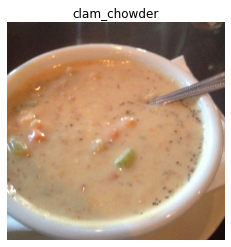

In [75]:

plt.imshow(preprocessed_img)
plt.title(class_names[label])
plt.axis(False);

In [76]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [78]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [28]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 
mixed_precision.set_global_policy(policy=None)

In [29]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "float32">

# Train ResNet50V2 on 100% Food101 data

In [82]:
js_model_path = "resnet_100pc_js_model"
saved_model_path = "resnet_100pc__model"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

resnet_feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         name="feature_extraction_layer")


x = resnet_feature_extractor_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)


outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [83]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               206949    
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Epoch 1/5
2368/2368 [==============================] - 159s 65ms/step - loss: 2.4800 - accuracy: 0.4172 - val_loss: 1.7366 - val_accuracy: 0.5578
Epoch 2/5
2368/2368 [==============================] - 156s 65ms/step - loss: 2.0335 - accuracy: 0.5073 - val_loss: 1.7299 - val_accuracy: 0.5649
Epoch 3/5
2368/2368 [==============================] - 155s 65ms/step - loss: 1.9404 - accuracy: 0.5262 - val_loss: 1.6622 - val_accuracy: 0.5795
Epoch 4/5
2368/2368 [==============================] - 155s 65ms/step - loss: 1.8830 - accuracy: 0.5383 - val_loss: 1.6611 - val_accuracy: 0.5795
Epoch 5/5
2368/2368 [==============================] - 155s 65ms/step - loss: 1.8549 - accuracy: 0.5462 - val_loss: 1.6978 - val_accuracy: 0.5716


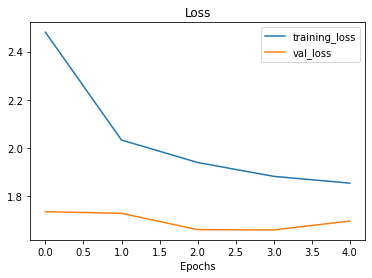

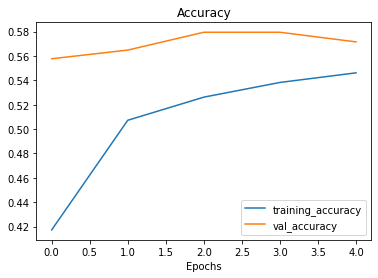

In [84]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data))
                                 )
plot_loss_curves(resnet_history)

## Save and convert ResNet to TFSJ

In [85]:
# 58% accuracy using 100% data vs 46% on 10% of data
resnet_model.evaluate(test_data)

790/790 [==============================] - 46s 58ms/step - loss: 1.6846 - accuracy: 0.5787


[1.684646487236023, 0.5786930918693542]

In [86]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
resnet_model.save(saved_model_path)

# Save model backup to Google Drive 
resnet_model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: resnet_100pc__model/assets


INFO:tensorflow:Assets written to: resnet_100pc__model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/resnet_100pc_js_model/resnet_100pc__model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/resnet_100pc_js_model/resnet_100pc__model/assets


In [87]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 112kB 9.4MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


2021-06-01 21:15:04.753345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01 21:15:09.267470: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-01 21:15:09.319654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-01 21:15:09.320219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-01 21:15:09.320337: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01 21:15:09.372891: I tensorflow/stream_executor/pl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train MobileNetV2 feature extraction model on 100% Food101 data

In [92]:
js_model_path = "mobilenet_v2_100pc_js_model"
saved_model_path = "mobilenet_v2_100pc_model"

mobile_net_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

feature_extract_layer = hub.KerasLayer(mobile_net_v2_url,
                                         trainable=False,
                                         name="feature_extract_layer")

x = feature_extract_layer(inputs)

x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature_extract_layer (Keras (None, 1280)              2257984   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


In [93]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)
resnet_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               206949    
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


Saving TensorBoard log files to: tensorflow_hub/feature_extract_mobile_net_v2/20210601-212019
Epoch 1/5
2368/2368 [==============================] - 154s 63ms/step - loss: 2.2546 - accuracy: 0.4487 - val_loss: 1.5048 - val_accuracy: 0.6044
Epoch 2/5
2368/2368 [==============================] - 148s 62ms/step - loss: 1.8211 - accuracy: 0.5430 - val_loss: 1.4575 - val_accuracy: 0.6151
Epoch 3/5
2368/2368 [==============================] - 148s 62ms/step - loss: 1.7379 - accuracy: 0.5594 - val_loss: 1.4780 - val_accuracy: 0.6104
Epoch 4/5
2368/2368 [==============================] - 148s 62ms/step - loss: 1.6938 - accuracy: 0.5700 - val_loss: 1.4571 - val_accuracy: 0.6159
Epoch 5/5
2368/2368 [==============================] - 150s 63ms/step - loss: 1.6731 - accuracy: 0.5735 - val_loss: 1.4654 - val_accuracy: 0.6119


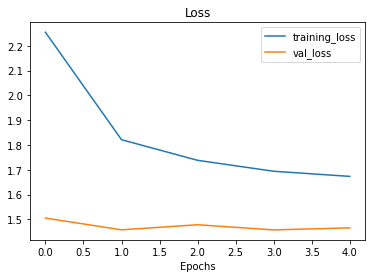

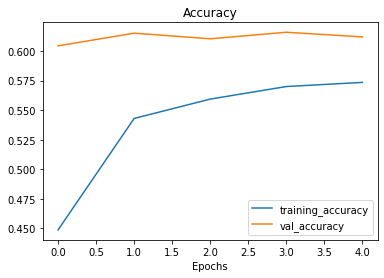

In [94]:
model_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=int(len(train_data)),
                                  validation_data=test_data,
                                  validation_steps=int(0.1*len(test_data)),
                                  callbacks=[create_tensorboard_callback("tensorflow_hub", "feature_extract_mobile_net_v2")]
                                 )
plot_loss_curves(model_history)

In [95]:
# 61% on full data vs 52% on 10%
model.evaluate(test_data)

790/790 [==============================] - 43s 54ms/step - loss: 1.4744 - accuracy: 0.6137


[1.4744170904159546, 0.6137029528617859]

In [96]:
save_dir = "/content/drive/MyDrive/ML/food_vision/"+js_model_path+"/"

# Save model locally
model.save(saved_model_path)

# Save model backup to Google Drive 
model.save(save_dir+saved_model_path)

INFO:tensorflow:Assets written to: mobilenet_v2_100pc_model/assets


INFO:tensorflow:Assets written to: mobilenet_v2_100pc_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_100pc_js_model/mobilenet_v2_100pc_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML/food_vision/mobilenet_v2_100pc_js_model/mobilenet_v2_100pc_model/assets


In [97]:
!pip install tensorflowjs 

!mkdir "{js_model_path}"

!tensorflowjs_converter --input_format=tf_saved_model "{saved_model_path}/" "{js_model_path}/"

!zip -r "{js_model_path}.zip" "{js_model_path}" 

# Download the JS model
from google.colab import files
files.download(js_model_path+'.zip')

2021-06-01 21:35:55.734247: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01 21:35:59.512701: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-01 21:35:59.517606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-01 21:35:59.518059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-06-01 21:35:59.518104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01 21:35:59.541128: I tensorflow/stream_executor/pl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>